In [1]:
# importing data analysis libraries
import numpy as np
import pandas as pd
from scipy import stats

# importing visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
# overriding matplotlib 
sns.set()

# import datetime
import datetime as dt

# import the preprocessing classes
from sklearn.preprocessing import StandardScaler
from category_encoders import BinaryEncoder
from sklearn.preprocessing import MinMaxScaler

# import train/test split module
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score

# import the regressors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import plotly.express as px
# import metrics
from sklearn.metrics import mean_squared_error,r2_score
import pickle

# import warnings
import warnings 
warnings.filterwarnings('ignore')

In [2]:
#Loading the data
df=pd.read_csv("Walmart DataSet/Walmart DataSet.csv")
# df.set_index('Date',inplace=True)

In [3]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
#shape of the dataset
df.shape

(6435, 8)

In [5]:
#dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [6]:
#Dataset Description
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [7]:
#Checking if there are any null values in the dataset
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

There are no Null values in the dataset

In [8]:
#checking for duplicate values 

df.duplicated().sum()

0

## Outliers

Outliers, or data points that are significantly different from the rest of the data, can affect the accuracy and reliability of statistical measures such as the mean and standard deviation. To ensure that these measures accurately represent the data, it is necessary to identify and properly handle outliers. To address this issue, we will develop two functions: one to detect outliers and another to count them. These functions will help us identify and understand the impact of outliers on our data, and allow us to make informed decisions about how to handle them.

In [9]:
def find_outlier_rows(df, col, level='both'):
    """
    Finds the rows with outliers in a given column of a dataframe.

    This function takes a dataframe and a column as input, and returns the rows
    with outliers in the given column. Outliers are identified using the
    interquartile range (IQR) formula. The optional level parameter allows the
    caller to specify the level of outliers to return, i.e., lower, upper, or both.

    Args:
        df: The input dataframe.
        col: The name of the column to search for outliers.
        level: The level of outliers to return, i.e., 'lower', 'upper', or 'both'.
               Defaults to 'both'.

    Returns:
        A dataframe containing the rows with outliers in the given column.
    """
    # compute the interquartile range
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)

    # compute the upper and lower bounds for identifying outliers
    lower_bound = df[col].quantile(0.25) - 1.5 * iqr
    upper_bound = df[col].quantile(0.75) + 1.5 * iqr

    # filter the rows based on the level of outliers to return
    if level == 'lower':
        return df[df[col] < lower_bound]
    elif level == 'upper':
        return df[df[col] > upper_bound]
    else:
        return df[(df[col] > upper_bound) | (df[col] < lower_bound)]

In [10]:
def count_outliers(df):
    """
    This function takes in a DataFrame and returns a DataFrame containing the count and 
    percentage of outliers in each numeric column of the original DataFrame.

    Input:
        df: a Pandas DataFrame containing numeric columns

    Output:
        a Pandas DataFrame containing two columns:
        'outlier_counts': the number of outliers in each numeric column
        'outlier_percent': the percentage of outliers in each numeric column
    """
    # select numeric columns
    df_numeric = df.select_dtypes(include=['int', 'float'])

    # get column names
    columns = df_numeric.columns

    # find the name of all columns with outliers
    outlier_cols = [col for col in columns if len(find_outlier_rows(df_numeric, col)) != 0]

    # dataframe to store the results
    outliers_df = pd.DataFrame(columns=['outlier_counts', 'outlier_percent'])

    # count the outliers and compute the percentage of outliers for each column
    for col in outlier_cols:
        outlier_count = len(find_outlier_rows(df_numeric, col))
        all_entries = len(df[col])
        outlier_percent = round(outlier_count * 100 / all_entries, 2)

        # store the results in the dataframe
        outliers_df.loc[col] = [outlier_count, outlier_percent]

    # return the resulting dataframe
    return outliers_df

In [11]:
# count the outliers in sales dataframe
count_outliers(df).sort_values('outlier_counts', ascending=False)

,outlier_counts,outlier_percent
Unemployment,481.0,7.47
Holiday_Flag,450.0,6.99
Weekly_Sales,34.0,0.53
Temperature,3.0,0.05


The above dataframe shows that weekly_sales, holiday_flag, temperature and unemployment columns all have outliers with unemployment having the largest outlier percentage, 7%. Let’s examine the outliers in each column to decide on how to handle them.

In [12]:
# calculate the employment rate
df['employment'] = 100 - df['Unemployment']
df['Date'] = pd.to_datetime(df['Date'])
# split the date column
df['year']= df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,employment,year,month,day
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106,91.894,2010,5,2
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,91.894,2010,12,2
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,91.894,2010,2,19
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,91.894,2010,2,26
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106,91.894,2010,5,3


## Distribution of the dataset

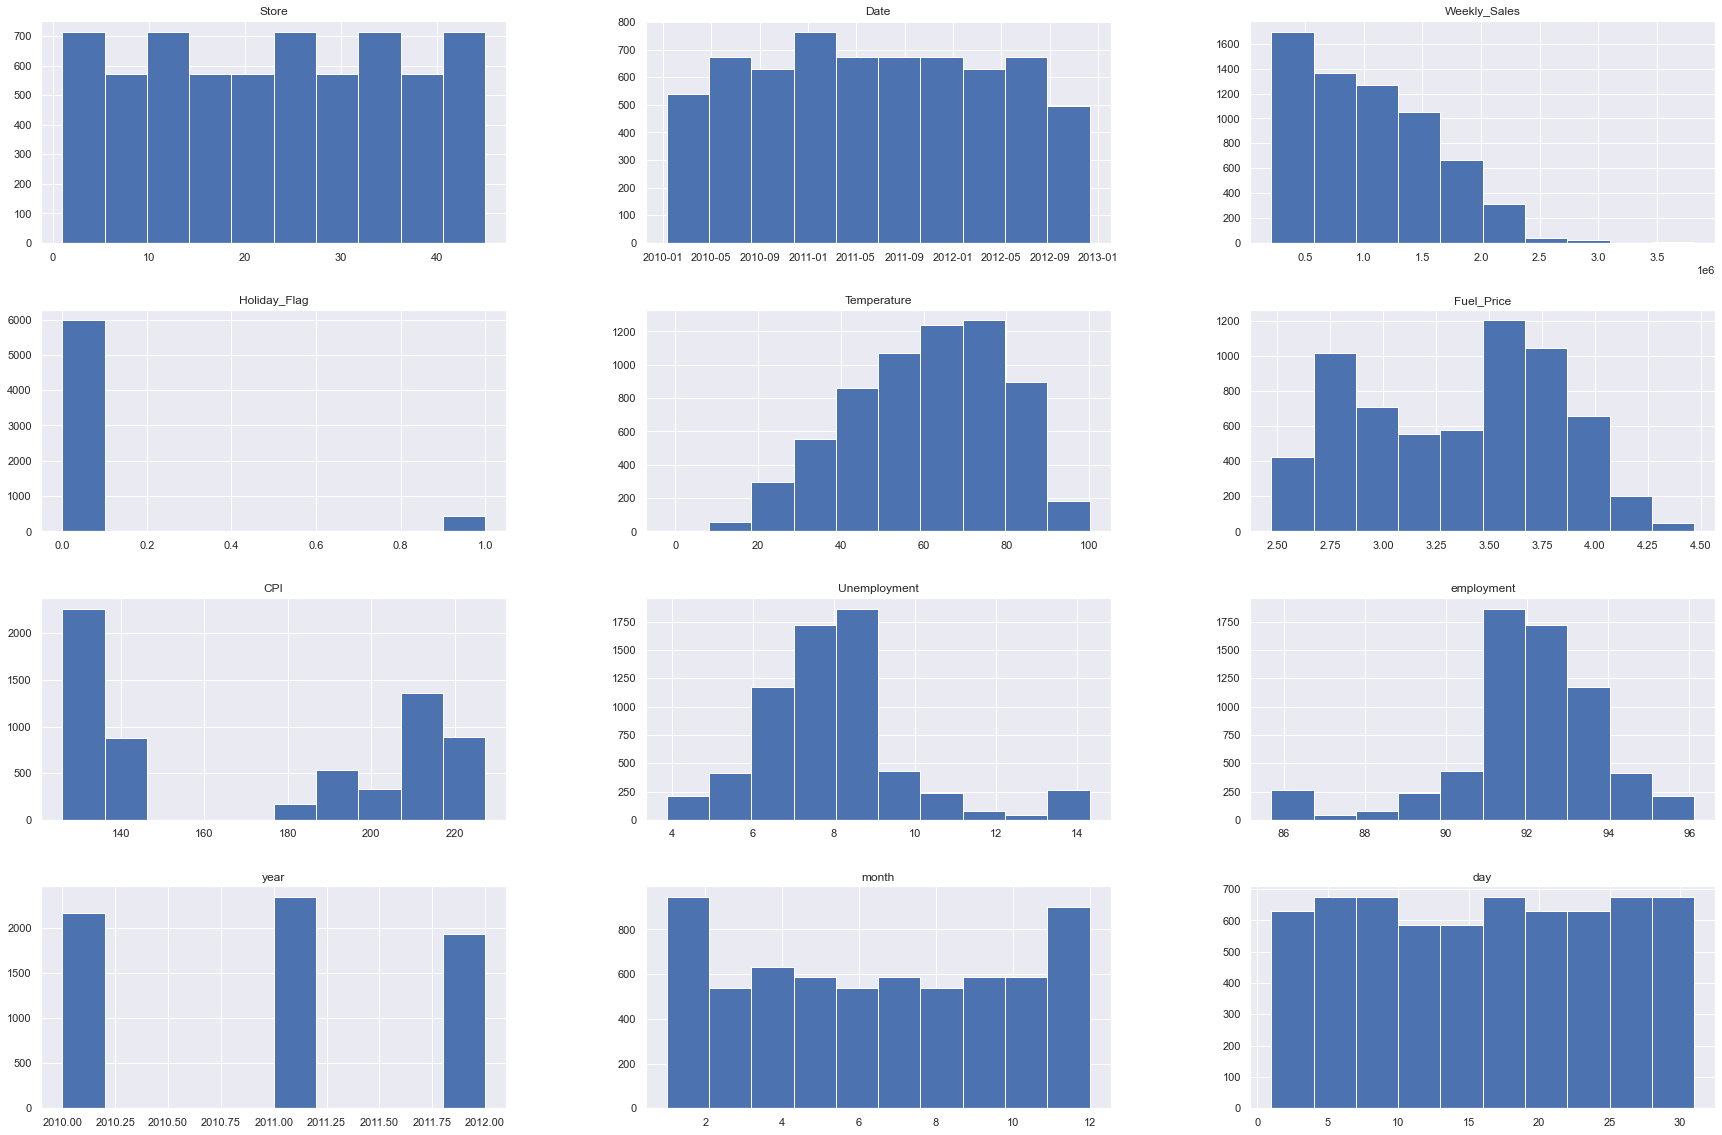

In [13]:
# histograms
df.hist(figsize=(30,20));

From the above histograms, we can understand that:

the number of transactions occurred almost evenly across various stores and years.

The distribution of weekly_sales right-skewed. Only a few of the weekly sales are above 2 million USD.

The distribution of temperature is approximately normal.

The distribution of fuel_price is bi-modal.

CPI formed two clusters.

unemployment rate is near normally distributed.

Four consecutive months November-February recorded the highest sales.

In [14]:
# # correct data format of the 'date' column
# df['Date'] = pd.to_datetime(df['Date'], format = "%d-%m-%Y")

# Create a new column "year" containing the year
df['year'] = df['Date'].dt.year

# Create a new column "quarter" containing the season number
df['quarter'] = df['Date'].dt.quarter

# Create a new column "month" containing the month number
df['month'] = df['Date'].dt.month

# Create a new column "month_name" containing the month names
df['month_name'] = df['Date'].dt.month_name()

# Create a new column "week" containing the week number
df['week'] = df['Date'].dt.isocalendar().week

# Create a new column "day_of_week" containing the day names
df['day_of_week'] = df['Date'].dt.day_name()

In [15]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,employment,year,month,day,quarter,month_name,week,day_of_week
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106,91.894,2010,5,2,2,May,17,Sunday
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,91.894,2010,12,2,4,December,48,Thursday
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,91.894,2010,2,19,1,February,7,Friday
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,91.894,2010,2,26,1,February,8,Friday
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106,91.894,2010,5,3,2,May,18,Monday


In [16]:
df['week'] = df['week'].astype('int32')

# EDA

In [17]:
#correlation among the features:
df.corr()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,employment,year,month,day,quarter,week
Store,1.000000e+00,-0.335332,-4.386841e-16,-0.022659,0.060023,-0.209492,0.223531,-0.223531,3.474318e-12,6.289676e-16,-1.070464e-15,-2.438190e-15,1.038488e-15
Weekly_Sales,-3.353320e-01,1.000000,3.689097e-02,-0.063810,0.009464,-0.072634,-0.106176,0.106176,-1.837754e-02,6.753523e-02,-1.487292e-02,5.680360e-02,6.610484e-02
Holiday_Flag,-4.386841e-16,0.036891,1.000000e+00,-0.155091,-0.078347,-0.002162,0.010960,-0.010960,-5.678257e-02,3.322341e-01,-3.603594e-02,3.300069e-01,3.288032e-01
Temperature,-2.265908e-02,-0.063810,-1.550913e-01,1.000000,0.144982,0.176888,0.101158,-0.101158,6.426923e-02,6.643970e-02,8.901925e-02,6.943104e-02,7.318701e-02
Fuel_Price,6.002295e-02,0.009464,-7.834652e-02,0.144982,1.000000,-0.170642,-0.034684,0.034684,7.794703e-01,-5.283174e-02,3.253169e-02,-5.051000e-02,-4.193804e-02
CPI,-2.094919e-01,-0.072634,-2.162091e-03,0.176888,-0.170642,1.000000,-0.302020,0.302020,7.479573e-02,1.478843e-03,3.965821e-03,8.830159e-04,2.782979e-03
Unemployment,2.235313e-01,-0.106176,1.096028e-02,0.101158,-0.034684,-0.302020,1.000000,-1.000000,-2.418135e-01,-2.061552e-03,-8.166853e-03,-3.863446e-03,-6.038021e-03
employment,-2.235313e-01,0.106176,-1.096028e-02,-0.101158,0.034684,0.302020,-1.000000,1.000000,2.418135e-01,2.061552e-03,8.166853e-03,3.863446e-03,6.038021e-03
year,3.474318e-12,-0.018378,-5.678257e-02,0.064269,0.779470,0.074796,-0.241813,0.241813,1.000000e+00,-1.390145e-01,-1.277942e-02,-1.338171e-01,-1.269874e-01
month,6.289676e-16,0.067535,3.322341e-01,0.066440,-0.052832,0.001479,-0.002062,0.002062,-1.390145e-01,1.000000e+00,5.959249e-03,9.685016e-01,9.964777e-01


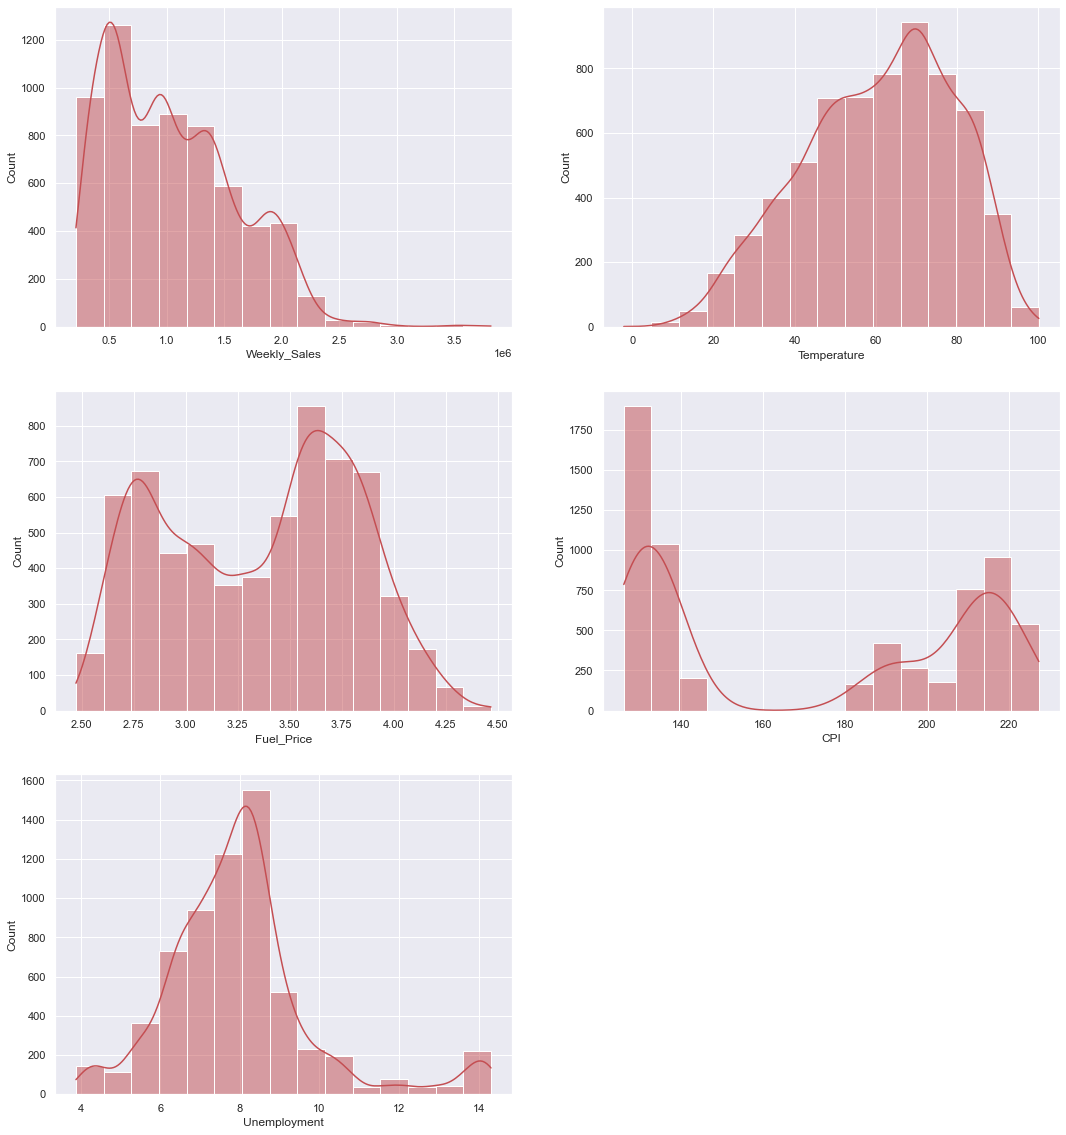

In [18]:
column=['Weekly_Sales', 'Temperature','Fuel_Price', 'CPI', 'Unemployment']
plt.figure(figsize=(18, 20))
for i,col in enumerate(column):
    plt.subplot(3, 2, i+1)
    sns.histplot(data = df, x = col, kde = True, bins = 15, color = 'r')
plt.show()

Conclusion:

The distribution of Weekly_Sales is right skewed, this is normal because the weekly sales may be high in some time.

Temperature and Unemployment have normal distribution.

CPI and Fuel_Price have bimodal distribution.

## EDA on categorical features

In [19]:
holiday_flag=df['Holiday_Flag'].value_counts()
holiday_flag

0    5985
1     450
Name: Holiday_Flag, dtype: int64

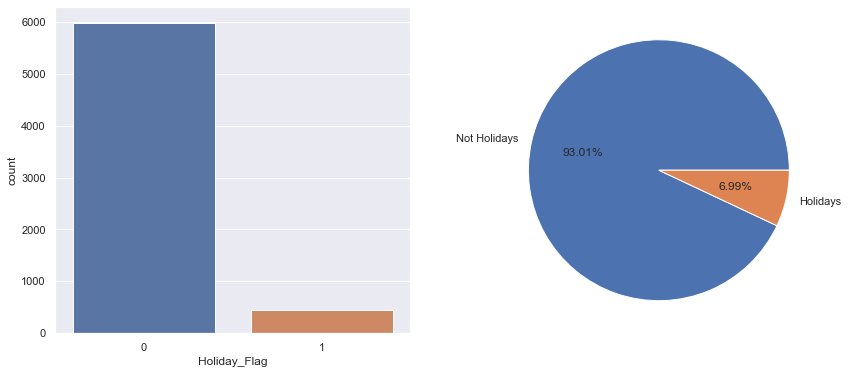

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
sns.countplot(data = df, x = 'Holiday_Flag', ax = ax[0])

ax[1].pie(df['Holiday_Flag'].value_counts().values,
          labels = ['Not Holidays', 'Holidays'],
          autopct = '%1.2f%%')

plt.show()

Conclusion:

Days of no holiday are the most frequent than days of holiday in the dataset with a percentage of 93 % and this is normal.

In [21]:
df['year'].value_counts()

2011    2340
2010    2160
2012    1935
Name: year, dtype: int64

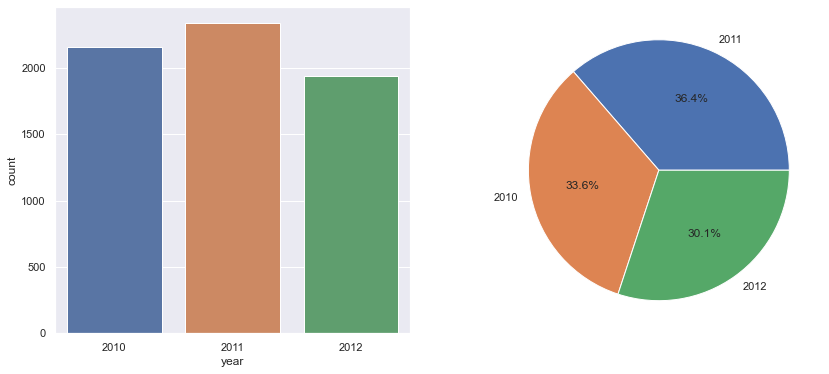

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
sns.countplot(data = df, x = 'year', ax = ax[0])
ax[1].pie(df['year'].value_counts().values,
          labels = df['year'].value_counts().index,
          autopct = '%1.1f%%')
plt.show()

Conclusion:

2011 is the most frequent in the dataset because most of the weekly sales were recorded during this year.

In [23]:
df['month_name'].value_counts()

April        630
May          585
September    585
July         585
October      585
March        540
June         540
August       540
December     495
February     495
January      450
November     405
Name: month_name, dtype: int64

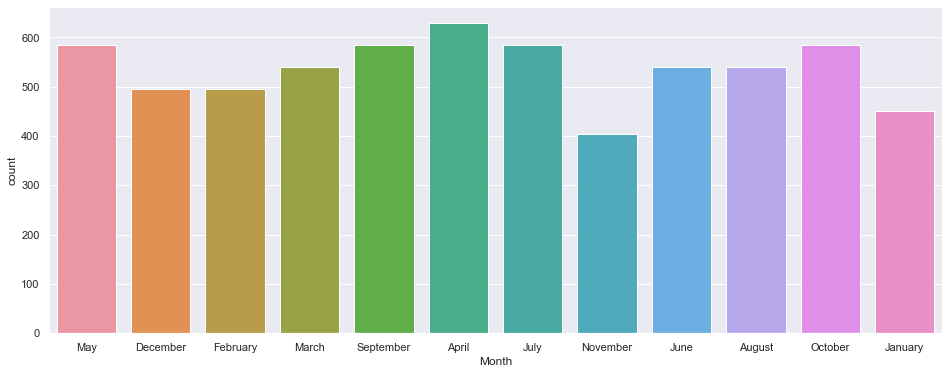

In [24]:
plt.figure(figsize=(16, 6))
sns.countplot(data = df, x = 'month_name')
plt.xlabel('Month')
plt.show()

Conclusion:

April and July are the most frequent in the dataset because most of the weekly sales were recorded in these months.

In [25]:
df['Store'].value_counts()

1     143
24    143
26    143
27    143
28    143
29    143
30    143
31    143
32    143
33    143
34    143
35    143
36    143
37    143
38    143
39    143
40    143
41    143
42    143
43    143
44    143
25    143
23    143
2     143
22    143
3     143
4     143
5     143
6     143
7     143
8     143
9     143
10    143
11    143
12    143
13    143
14    143
15    143
16    143
17    143
18    143
19    143
20    143
21    143
45    143
Name: Store, dtype: int64

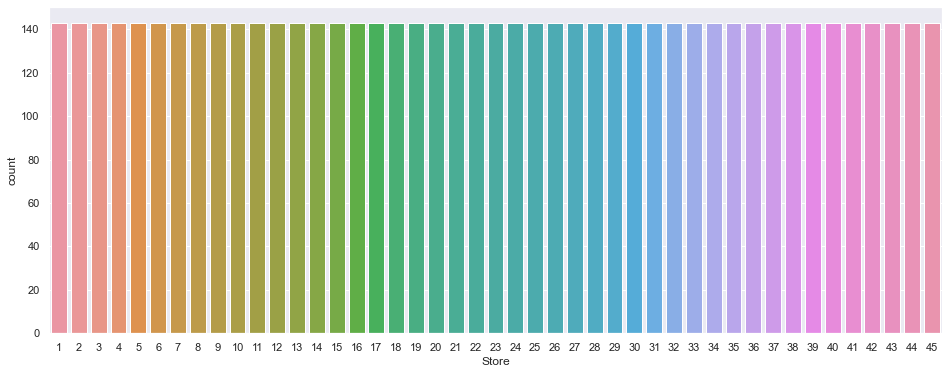

In [26]:
plt.figure(figsize=(16, 6))
sns.countplot(data = df, x = 'Store')
plt.show()

Conclusion:

All stores are frequent with the same count in the dataset.

## 1. If the weekly sales are affected by the unemployment rate, if yes - which stores are suffering the most?

### Pearson Correlation

The Pearson Correlation measures the linear dependence between two variables X and Y.

The resulting coefficient is a value between -1 and 1 inclusive, where:

1: Perfect positive linear correlation.

0: No linear correlation, the two variables most likely do not affect each other.

-1: Perfect negative linear correlation.

In [27]:
# Let's calculate the Pearson Correlation Coefficient and P-value of 'unemployment' and 'weekly_sales':
pearson_coef, p_value = stats.pearsonr(df['Unemployment'], df['Weekly_Sales'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.1061760896579542  with a P-value of P = 1.3448365210357873e-17


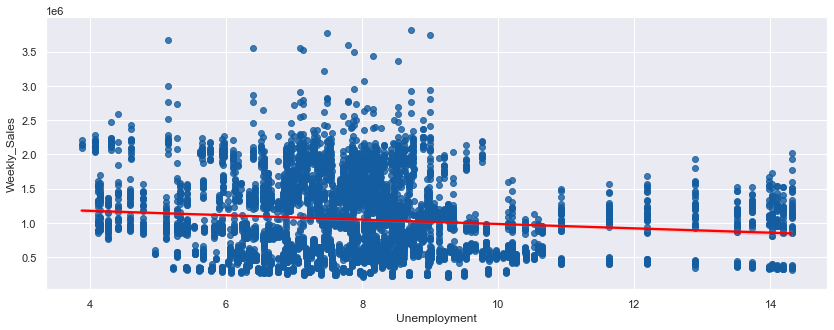

In [28]:
plt.figure(figsize = (14, 5))
sns.regplot(data = df, x = 'Unemployment', y = 'Weekly_Sales', color = '#145DA0', line_kws = {'color': 'red'})
plt.show()

Conclusion:-

Since the p-value is < 0.001, the correlation between unemployment and weekly sales is strong evidence that the correlation is significant.

Unemployment seems like a good predictor of the weekly sales, The higher the unemployment rate, the lower the weekly sales.

In [29]:
df[df['Unemployment']==df['Unemployment'].max()]['Store'].value_counts()

12    14
28    14
38    14
Name: Store, dtype: int64

Stores 12,28 and 38 are affected by high Unemployment 

## 2. If the weekly sales show a seasonal trend, when and what could be the reason?

Seasonality trends analysis can be extremely valuable for businesses, as it allows us to better forecast future sales, make more informed decisions about inventory and staffing, and understand the drivers of customer demand leading to improved efficiency and profitability.

We will create a pivot table to group the data by month and year and calculate the average sales for each period. We will then plot the average sales of the table using line chart for the three years. This will allow us to see if there are any patterns in the data that repeat at regular intervals.

In [30]:
# create the pivot table
pivot_table = df.pivot_table(index='month', columns='year', values='Weekly_Sales')
# display the pivot table
pivot_table

year,2010,2011,2012
month,,,
1,9.386639e+05,9.420697e+05,9.567817e+05
2,1.064372e+06,1.042273e+06,1.057997e+06
3,1.034590e+06,1.011263e+06,1.025510e+06
4,1.021177e+06,1.033220e+06,1.014127e+06
5,1.039303e+06,1.015565e+06,1.053948e+06
6,1.055082e+06,1.038471e+06,1.082920e+06
7,1.023702e+06,9.976049e+05,1.025480e+06
8,1.025212e+06,1.044895e+06,1.064514e+06
9,9.983559e+05,1.026810e+06,9.988663e+05


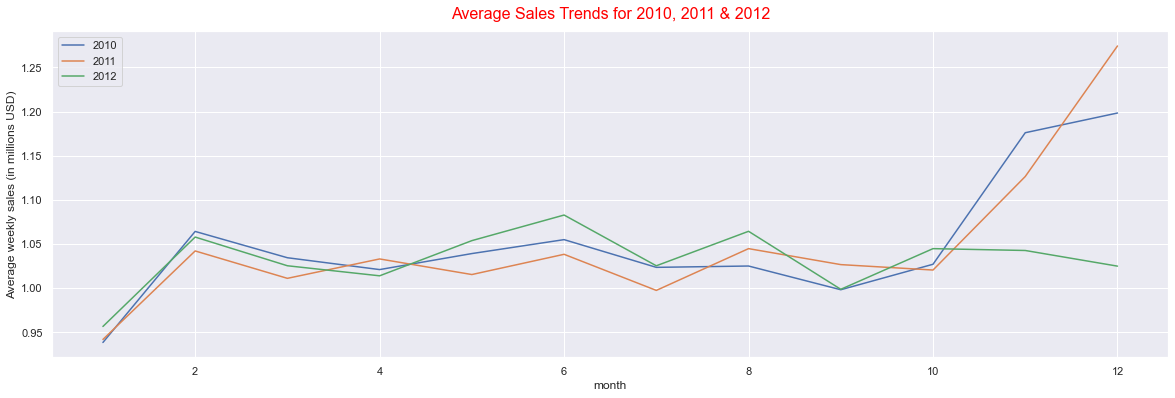

In [31]:
# plot the average sales
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_palette("bright")
sns.lineplot(x=pivot_table.index, y=pivot_table[2010]/1e6, ax=ax, label='2010')
sns.lineplot( x=pivot_table.index, y=pivot_table[2011]/1e6, ax=ax, label='2011')
sns.lineplot( x=pivot_table.index, y=pivot_table[2012]/1e6, ax=ax, label='2012')
plt.ylabel('Average weekly sales (in millions USD)')
plt.title('Average Sales Trends for 2010, 2011 & 2012', fontdict ={'fontsize':16,
                                                                   'color':'red',
                                                                   'horizontalalignment': 'center'},
                                                                   pad=12)
# Add a legend
plt.legend()
plt.show()

We can observe that the line charts for the three years for the month of January to October simultaneously follow a sawtooth shape with big rises experienced in November and December due to holidays. This indicates seasonality trends as months do have consistencies in bigger or smaller sales for the three years. We can also observe that although 2011 performed worst than 2010 in terms of average sales for Walmart, the trend was reversed for the year 2012 which performed better than 2010. However, the data for 2012 ends in October, which may explain the significant drop in sales for November."

## 3. Does temperature affect the weekly sales in any manner?

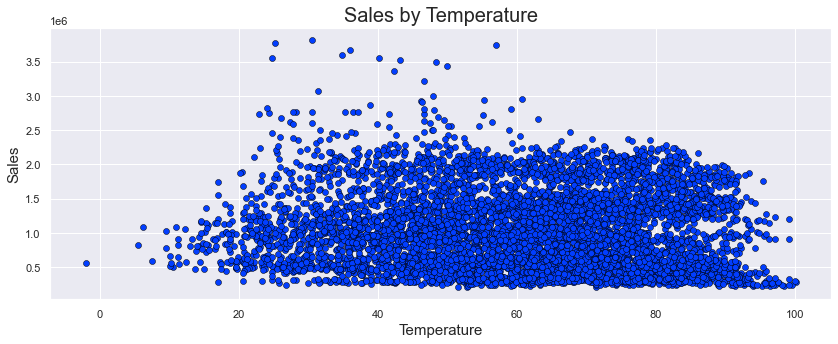

In [32]:
plt.figure(figsize = (14, 5))
sns.scatterplot(data = df,
                x = 'Temperature',
                y = 'Weekly_Sales',
                edgecolor = "black")

# Add labels and title
plt.title('Sales by Temperature', size = 20)
plt.xlabel('Temperature', size = 15)
plt.ylabel('Sales', size = 15)
plt.show()

Conclusion:

Sales are not affected by changes in temperature.

## 4. How is the Consumer Price index affecting the weekly sales of various stores?

In [33]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'employment', 'year', 'month',
       'day', 'quarter', 'month_name', 'week', 'day_of_week'],
      dtype='object')

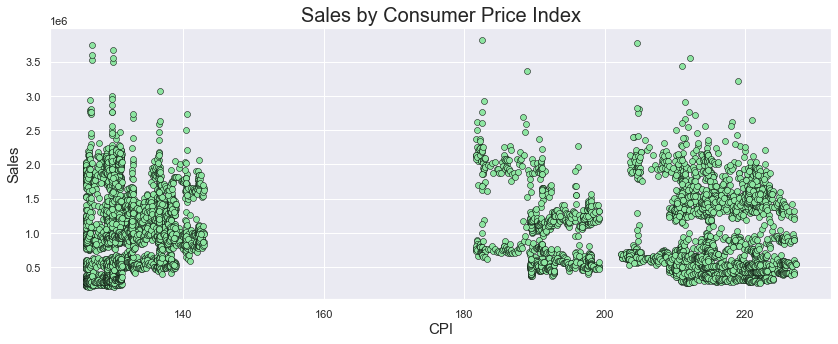

In [34]:
plt.figure(figsize = (14, 5))
sns.scatterplot(data = df,
                x = 'CPI',
                y = 'Weekly_Sales',
                color = '#8de5a1',
                edgecolor = "black")

# Add labels and title
plt.title('Sales by Consumer Price Index', size = 20)
plt.xlabel('CPI', size = 15)
plt.ylabel('Sales', size = 15)
plt.show()

Conclusion:

Consumer Price Index (CPI) does not affect sales. And based on the distribution of average consumer prices in the above figure, customers can be divided into two categories:

customers who pay from 120 to 150 (Middle-class customers).

customers who pay from 180 to 230 (High-class customers).

## 5. Top performing stores according to the historical data.

In [35]:
top_performing_store = df.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending = False)
top_performing_store

Store
20    3.013978e+08
4     2.995440e+08
14    2.889999e+08
13    2.865177e+08
2     2.753824e+08
10    2.716177e+08
27    2.538559e+08
6     2.237561e+08
1     2.224028e+08
39    2.074455e+08
19    2.066349e+08
31    1.996139e+08
23    1.987506e+08
24    1.940160e+08
11    1.939628e+08
28    1.892637e+08
41    1.813419e+08
32    1.668192e+08
18    1.551147e+08
22    1.470756e+08
12    1.442872e+08
26    1.434164e+08
34    1.382498e+08
40    1.378703e+08
35    1.315207e+08
8     1.299512e+08
17    1.277821e+08
45    1.123953e+08
21    1.081179e+08
25    1.010612e+08
43    9.056544e+07
15    8.913368e+07
7     8.159828e+07
42    7.956575e+07
9     7.778922e+07
29    7.714155e+07
16    7.425243e+07
37    7.420274e+07
30    6.271689e+07
3     5.758674e+07
38    5.515963e+07
36    5.341221e+07
5     4.547569e+07
44    4.329309e+07
33    3.716022e+07
Name: Weekly_Sales, dtype: float64

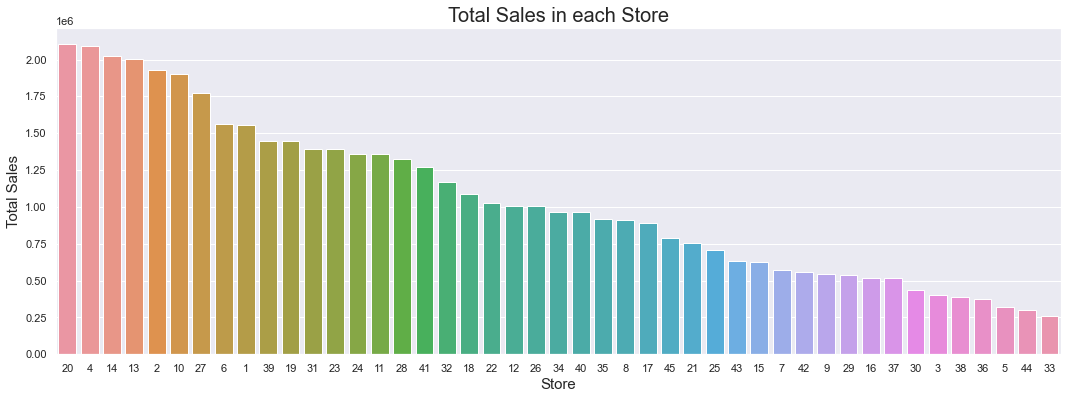

In [36]:
plt.figure(figsize = (18, 6))
sns.barplot(data = df,
            x = 'Store',
            y = 'Weekly_Sales',
            order = top_performing_store.index,
            ci = False)

# Add labels and title
plt.title('Total Sales in each Store', size = 20)
plt.xlabel('Store', size = 15)
plt.ylabel('Total Sales', size = 15)
plt.show()

Conclusion:

There is a high variance in weekly sales from one store to another.

Store No. 20 has the highest sales from any store with 301,397,792 followed by Store No. 4 with 299,543,953 and Store No. 33 comes last with 37,160,222$.

## 6.The worst performing store, and how significant is the difference between the highest and lowest performing stores.

In [37]:
worst_performing_store = df.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending = True)
worst_performing_store

Store
33    3.716022e+07
44    4.329309e+07
5     4.547569e+07
36    5.341221e+07
38    5.515963e+07
3     5.758674e+07
30    6.271689e+07
37    7.420274e+07
16    7.425243e+07
29    7.714155e+07
9     7.778922e+07
42    7.956575e+07
7     8.159828e+07
15    8.913368e+07
43    9.056544e+07
25    1.010612e+08
21    1.081179e+08
45    1.123953e+08
17    1.277821e+08
8     1.299512e+08
35    1.315207e+08
40    1.378703e+08
34    1.382498e+08
26    1.434164e+08
12    1.442872e+08
22    1.470756e+08
18    1.551147e+08
32    1.668192e+08
41    1.813419e+08
28    1.892637e+08
11    1.939628e+08
24    1.940160e+08
23    1.987506e+08
31    1.996139e+08
19    2.066349e+08
39    2.074455e+08
1     2.224028e+08
6     2.237561e+08
27    2.538559e+08
10    2.716177e+08
2     2.753824e+08
13    2.865177e+08
14    2.889999e+08
4     2.995440e+08
20    3.013978e+08
Name: Weekly_Sales, dtype: float64

Worst performing store is store number 33 with 37,160,222. The significant difference between best performing store with sales 301,397,792 is 264,237,570

## correlations between the features of the dataset and weekly_sales

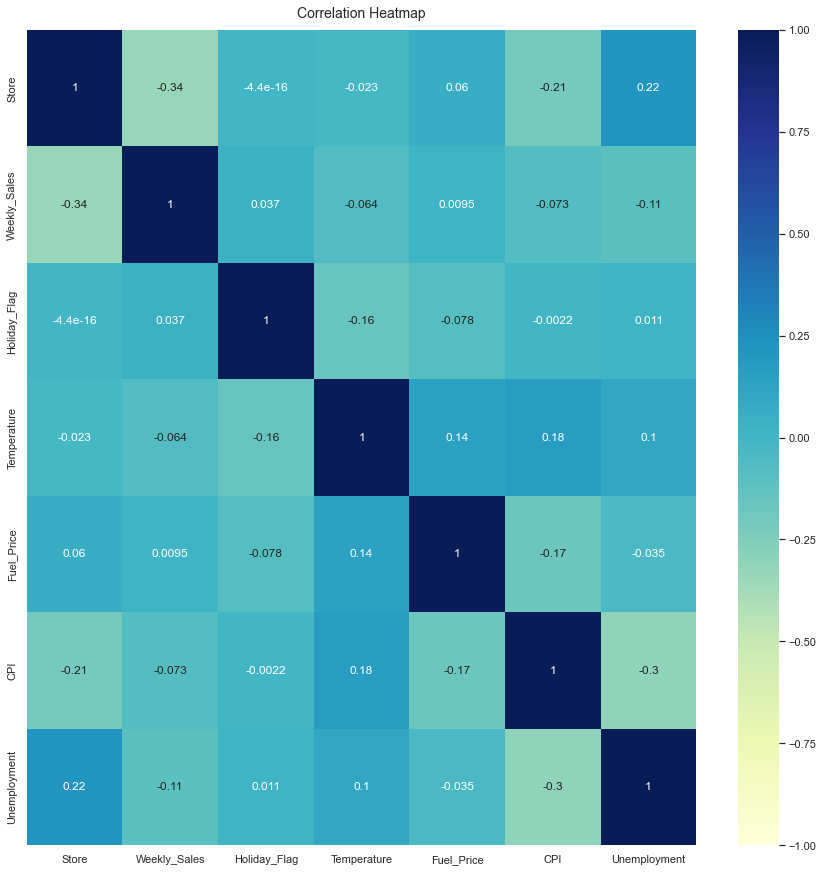

In [38]:
fig, ax = plt.subplots(figsize=(15,15))
heatmap = sns.heatmap(df[['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature','Fuel_Price', 'CPI', 'Unemployment']].corr(), vmin=-1, vmax=1, annot=True, cmap ="YlGnBu")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

## Model Selection and Evaluation

In [39]:
#Taking a copy of data

data_copy = df.copy()

In [40]:
data_copy.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'employment', 'year', 'month',
       'day', 'quarter', 'month_name', 'week', 'day_of_week'],
      dtype='object')

In [41]:
data_copy.drop(['Date', 'employment','month_name','day_of_week','week','quarter'], axis=1, inplace=True)

In [42]:
data_copy.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,2010,5,2
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,2010,12,2
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,19
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,26
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,2010,5,3


In [43]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
 7   year          6435 non-null   int64  
 8   month         6435 non-null   int64  
 9   day           6435 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 502.9 KB


In [44]:
# let's handle store and holiday columns as categorical features, so we should convert them into categories (objects).bb
data_copy['Store'] = data_copy['Store'].astype('object')
data_copy['Holiday_Flag'] = data_copy['Holiday_Flag'].astype('object')
data_copy['year']=data_copy['year'].astype('object')
data_copy['month']=data_copy['month'].astype('object')
data_copy['day']=data_copy['day'].astype('object')

In [45]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   object 
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   object 
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
 7   year          6435 non-null   object 
 8   month         6435 non-null   object 
 9   day           6435 non-null   object 
dtypes: float64(5), object(5)
memory usage: 502.9+ KB


## Removing Outliers

0 Fuel_Price
1 Temperature
2 CPI
3 Unemployment


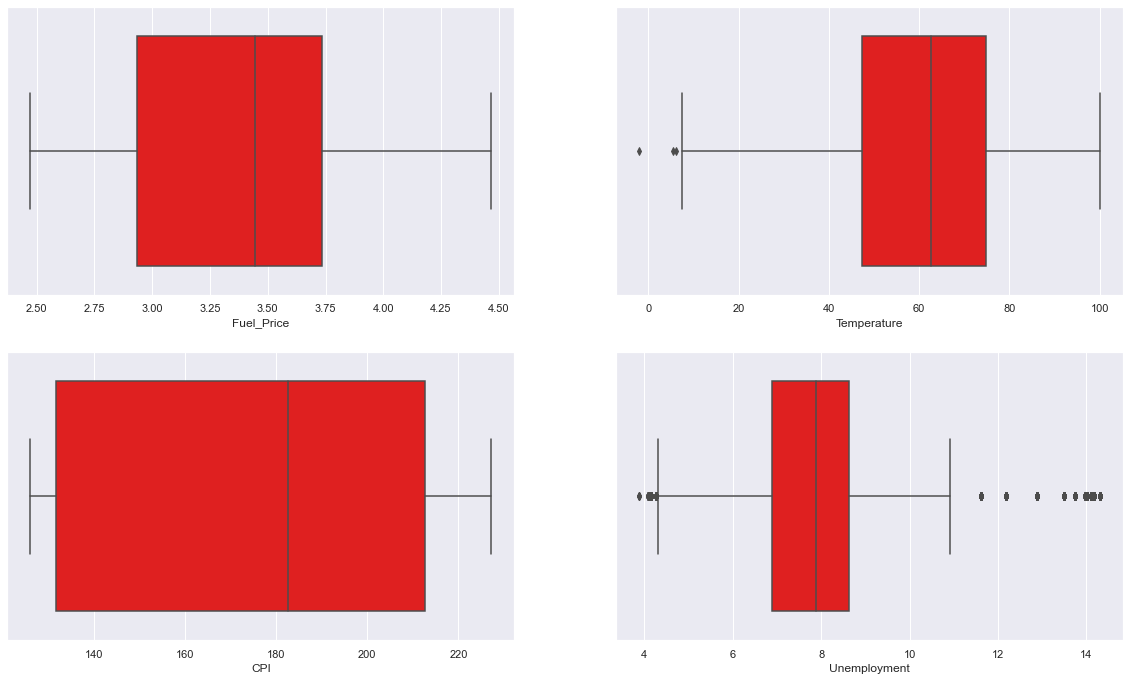

Number of data rows:  6435


In [46]:
cols = ['Fuel_Price', 'Temperature', 'CPI', 'Unemployment']
plt.figure(figsize=(20,18))
for i,col in enumerate(cols):
    print(i, col)
    plt.subplot(3,2,i+1)
    sns.boxplot(x = data_copy[col], color = 'red')
plt.show()

print('Number of data rows: ', data_copy.shape[0])

In [47]:
# Remove outliers from the temperature column
data_copy.drop(data_copy[data_copy['Temperature'] < 7].index, axis = 0, inplace = True)

In [48]:
# Remove outliers from the unemployment column
data_copy.drop(data_copy[data_copy['Unemployment'] < 4.4].index, axis = 0, inplace = True)
data_copy.drop(data_copy[data_copy['Unemployment'] > 11].index, axis = 0, inplace = True)

0 Fuel_Price
1 Temperature
2 CPI
3 Unemployment


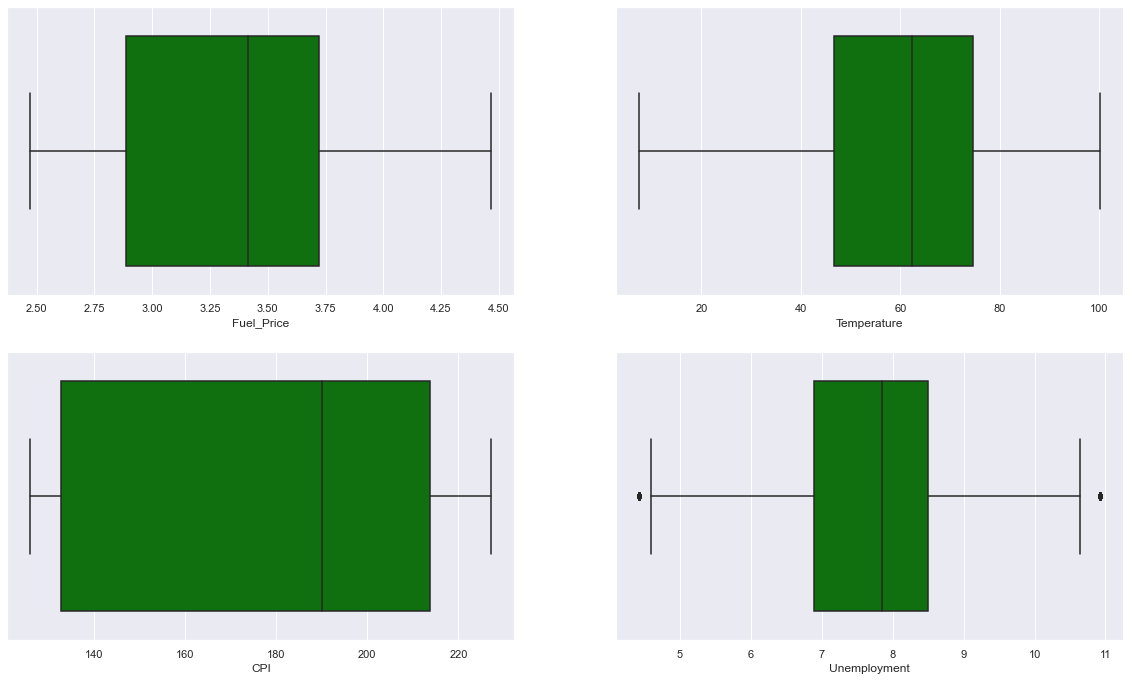

Number of data rows:  5938


In [49]:
cols = ['Fuel_Price', 'Temperature', 'CPI', 'Unemployment']
plt.figure(figsize=(20,18))
for i,col in enumerate(cols):
    print(i, col)
    plt.subplot(3,2,i+1)
    sns.boxplot(x = data_copy[col], color = 'green')
plt.show()

print('Number of data rows: ', data_copy.shape[0])

## Splitting the data to test and train

In [50]:
X = data_copy.drop('Weekly_Sales', axis = 1)
y = data_copy['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [51]:
print('Shape of data      : ', X.shape)
print('Shape of train data: ', X_train.shape)
print('Shape of test data : ', X_test.shape)

Shape of data      :  (5938, 9)
Shape of train data:  (4750, 9)
Shape of test data :  (1188, 9)


## Data Transformation

In [52]:
# Splitting the data into Numerical Features and Categorical Features
num_features = data_copy.select_dtypes('number').columns.to_list()
num_features.remove('Weekly_Sales')

cat_features = data_copy.select_dtypes('object').columns.to_list()

print(f'Numerical Features : {num_features}')
print(f'Categorical Features: {cat_features}')

Numerical Features : ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
Categorical Features: ['Store', 'Holiday_Flag', 'year', 'month', 'day']


In [53]:
# data transformation pipeline
preprocessor = ColumnTransformer([
                                  ('num_features', StandardScaler(), num_features),
                                  ('cat_features', BinaryEncoder(), cat_features),
                                ])

# Fitting the training data
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num_features', StandardScaler(),
                                 ['Temperature', 'Fuel_Price', 'CPI',
                                  'Unemployment']),
                                ('cat_features', BinaryEncoder(),
                                 ['Store', 'Holiday_Flag', 'year', 'month',
                                  'day'])])

In [54]:
# Transform the training data
X_train_transformed = preprocessor.transform(X_train)

# Transform the testing data
X_test_transformed = preprocessor.transform(X_test)

In [55]:
def model_evaluation(estimator, Training_Testing, X, y):

    ''' This function is used to evaluate the model through RMSE and R2'''

    # Y predict of X train or X test
    predict_data = estimator.predict(X)

    print(f'{Training_Testing} Accuracy: \n')
    print(f'-> Root Mean Squared Error: {round(np.sqrt(mean_squared_error(y, predict_data)), 2)}')
    print(f'-> R-Squere score Training: {round(r2_score(y, predict_data) * 100, 2)} % \n')

In [56]:
def Distribution_Plot(estimator, Training_Testing, X, y, Title):

    """This function is used to perform some model evaluation using training and testing data \
    by plotting the distribution of the actual and predicted values of the training or testing data."""

    # Y predict of X train or X test
    yhat = estimator.predict(X)

    plt.figure(figsize=(14, 6))
    ax1 = sns.distplot(y, hist = False, color = "b", label = f'Actual Values ({Training_Testing})')
    ax2 = sns.distplot(yhat, hist = False, color = "r", label = f'Predicted Values ({Training_Testing})', ax = ax1)
    plt.title(Title, size = 18)
    plt.legend()
    plt.show()

In [57]:
def cross_validation_score(estimator, X_train, y_train, score = 'r2', n = 5):

    '''This function is to validate the model'''


    validate = cross_val_score(estimator, X_train, y_train, scoring = score, cv = n)

    print(f'Cross Validation Scores: {validate} \n')
    print(f'Mean of Scores: {round(validate.mean() * 100, 2)} % \n')
    print(f'Standard Deviation of Scores: {validate.std()}')

In [58]:
def hyperparameter_tunning(estimator, X_train, y_train, param_grid, score = 'r2', n = 5):

    '''This function is used to find the best set of hyperparameters for the model to optimize its performance'''


    # Perform grid search
    grid_search = GridSearchCV(estimator = estimator,
                               param_grid = param_grid,
                               scoring = score,
                               cv = n)

    # Fit the data
    grid_search.fit(X_train,y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Print the best parameters and score
    print(f'Best parameters: {best_params} \n')
    print(f'Best score: {best_score}')

    # best estimator
    best_estimator = grid_search.best_estimator_

    return best_estimator

## 1.Linear Regression

In [59]:
# Linear Regression Model
LR = LinearRegression()

# Fitting the data
LR.fit(X_train_transformed, y_train)

LinearRegression()

In [60]:
# Training Accuracy
model_evaluation(LR, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 525536.16
-> R-Squere score Training: 14.99 % 



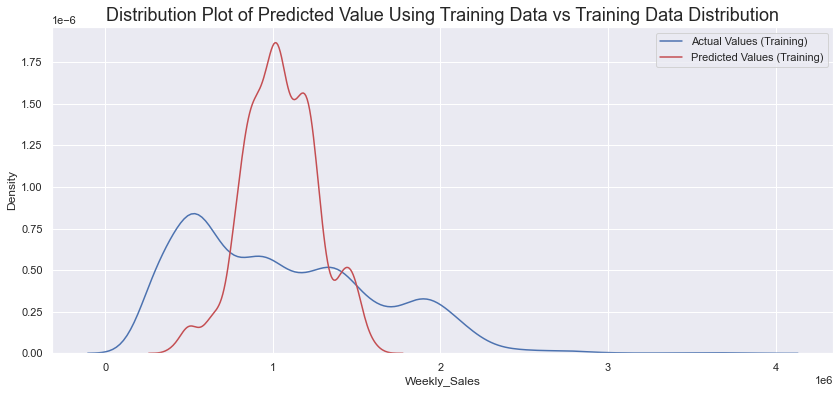

In [61]:
# Figure 1: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(LR, 'Training', X_train_transformed, y_train, Title)

#### Conclusion:

Since there are no linear correlations between variables and targets, The model seems to be not doing well in learning from the training dataset, so we need to increase the complexity of this model. let's do Polynomial Features for the data before modeling.

In [62]:
# Polynomial Regression Model
LR_pipe = Pipeline([('poly_feat', PolynomialFeatures()),
                    ('lin_reg', LinearRegression())])

# Define the parameter grid to search
param_grid = {'poly_feat__degree': [2, 3, 4]}

best_estimator = hyperparameter_tunning(LR_pipe, X_train_transformed, y_train, param_grid, score = 'r2', n = 5)

Best parameters: {'poly_feat__degree': 3} 

Best score: 0.9514798080044095


In [63]:
# Linear Regression Model after tuning
poly_reg = best_estimator

In [64]:
# Training Accuracy Afer tuning
model_evaluation(poly_reg, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 67608.93
-> R-Squere score Training: 98.59 % 



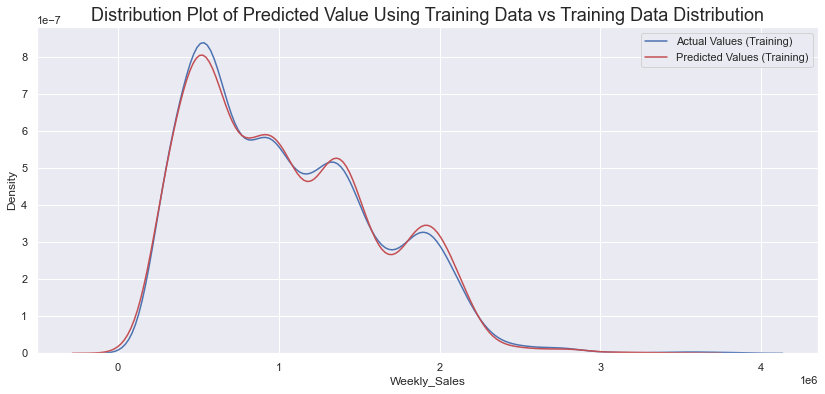

In [65]:
# Figure 2: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(poly_reg, 'Training', X_train_transformed, y_train, Title)

#### Conclusion:

After applying Polynomial Features to the training data, The model seems to have improved more in learning from the training dataset.

In [66]:
cross_validation_score(poly_reg, X_train_transformed, y_train)

Cross Validation Scores: [0.95194595 0.95233854 0.94968494 0.95843736 0.94499225] 

Mean of Scores: 95.15 % 

Standard Deviation of Scores: 0.004351369794724979


In [67]:
# Testing Accuracy
model_evaluation(poly_reg, 'Testing', X_test_transformed, y_test)

Testing Accuracy: 

-> Root Mean Squared Error: 115051.15
-> R-Squere score Training: 95.95 % 



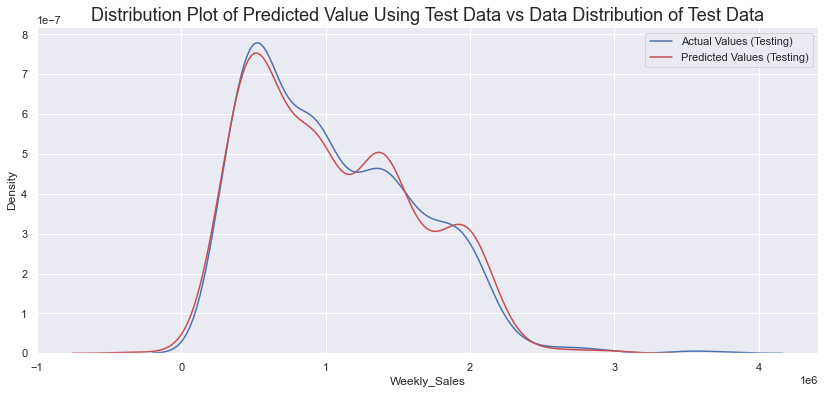

In [68]:
# Figure 3: Plot of predicted value using the test data compared to the actual values of the test data.
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
Distribution_Plot(poly_reg, 'Testing', X_test_transformed, y_test, Title)

#### Conclusion:

After testing the polynomial regression model, it became clear that the model had learned sufficiently, as its accuracy was 95.95 %.

## 2. KNN Regressor

In [69]:
# KNN Regression Model
KNN_Reg = KNeighborsRegressor(n_neighbors = 5)

# Fitting the training data
KNN_Reg.fit(X_train_transformed, y_train)

KNeighborsRegressor()

In [70]:
# Training Accuracy
model_evaluation(KNN_Reg, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 355737.84
-> R-Squere score Training: 61.05 % 



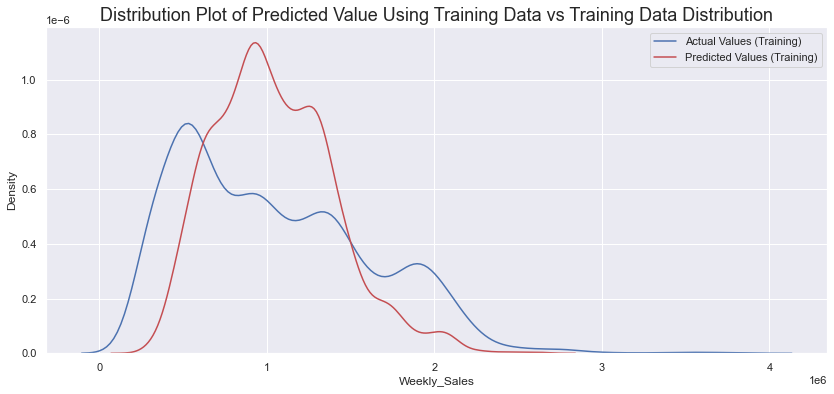

In [71]:
# Figure 1: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(KNN_Reg, 'Training', X_train_transformed, y_train, Title)

#### Conclusion:

The model seems to be doing not bad in learning from the training dataset.

### Tuning The Model

In [72]:
# Define the parameter grid to search
param_grid = {'n_neighbors': [1, 3, 5, 7, 8, 9, 11, 13]}

best_estimator = hyperparameter_tunning(KNN_Reg, X_train_transformed, y_train, param_grid, score = 'r2', n = 5)

Best_KNN = best_estimator

Best parameters: {'n_neighbors': 13} 

Best score: 0.5498314292968057


In [73]:
# Training Accuracy Afer tuning
model_evaluation(Best_KNN, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 355310.63
-> R-Squere score Training: 61.14 % 



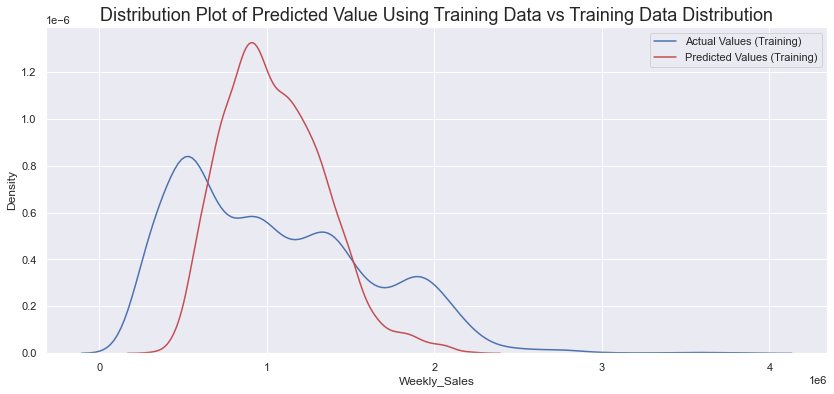

In [74]:
# Figure 2: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(Best_KNN, 'Training', X_train_transformed, y_train, Title)

### Cross Validation

In [75]:
cross_validation_score(Best_KNN, X_train_transformed, y_train, n = 10)

Cross Validation Scores: [0.53381489 0.51212115 0.51600077 0.5612408  0.5436867  0.56985853
 0.54726975 0.53916967 0.57586361 0.57034412] 

Mean of Scores: 54.69 % 

Standard Deviation of Scores: 0.02127681369771122


In [76]:
# Testing Accuracy
model_evaluation(Best_KNN, 'Testing', X_test_transformed, y_test)

Testing Accuracy: 

-> Root Mean Squared Error: 379471.23
-> R-Squere score Training: 55.97 % 



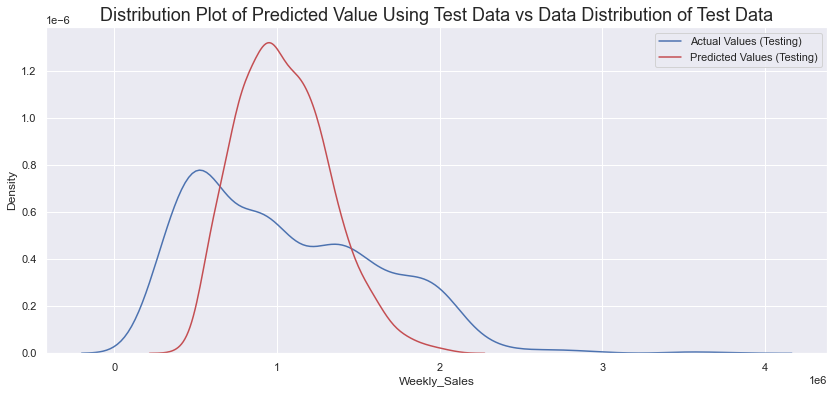

In [77]:
# Figure 3: Plot of predicted value using the test data compared to the actual values of the test data.
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
Distribution_Plot(Best_KNN, 'Testing', X_test_transformed, y_test, Title)

## 3. Decision Tree Regressor

In [78]:
# Decision Tree regressor Model
tree = DecisionTreeRegressor()

# Fitting the training data
tree.fit(X_train_transformed, y_train)

DecisionTreeRegressor()

In [79]:
# Training Accuracy
model_evaluation(tree, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 0.0
-> R-Squere score Training: 100.0 % 



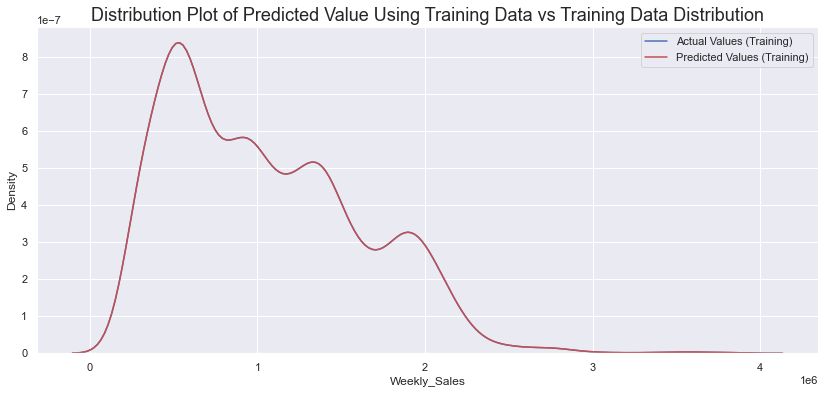

In [80]:
# Figure 1: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(tree, 'Training', X_train_transformed, y_train, Title)

#### Conclusion:

The model has overfitting, so let's improve it by tuning the hyperparameters..

In [81]:
# Define the parameter grid to search
param_grid = {'max_depth': np.arange(2, 15),
              'min_samples_split': [10, 20, 30, 40, 50, 100, 200, 300]}

best_estimator = hyperparameter_tunning(tree, X_train_transformed, y_train, param_grid, score = 'r2', n = 5)

Best_Tree = best_estimator

Best parameters: {'max_depth': 9, 'min_samples_split': 40} 

Best score: 0.9162894455943622


In [82]:
# Training Accuracy Afer tuning
model_evaluation(Best_Tree, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 142796.43
-> R-Squere score Training: 93.72 % 



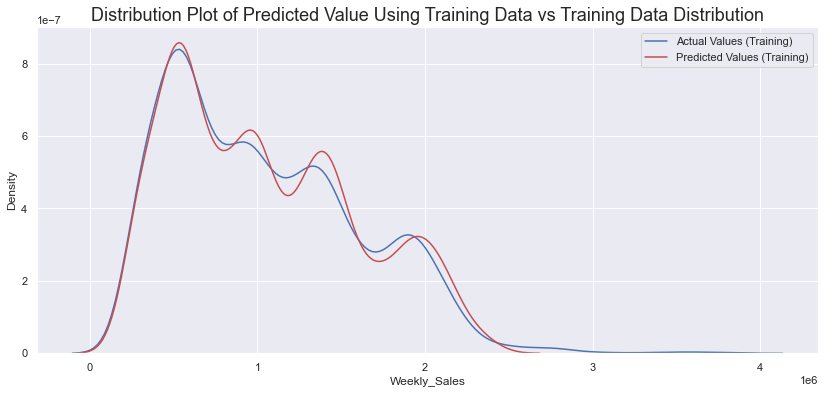

In [83]:
# Figure 2: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(Best_Tree, 'Training', X_train_transformed, y_train, Title)

#### Conclusion:

After tuning the hyperparameter of max_depth and min_samples_split, The model seems to have improved well in learning from the training dataset.

In [84]:
cross_validation_score(Best_Tree, X_train_transformed, y_train, n = 10)

Cross Validation Scores: [0.91088511 0.92631836 0.93405529 0.88520185 0.90697187 0.92107501
 0.93727483 0.91236738 0.88015814 0.92103333] 

Mean of Scores: 91.35 % 

Standard Deviation of Scores: 0.017970517159697226


In [85]:
# Testing Accuracy
model_evaluation(Best_Tree, 'Testing', X_test_transformed, y_test)

Testing Accuracy: 

-> Root Mean Squared Error: 160666.31
-> R-Squere score Training: 92.11 % 



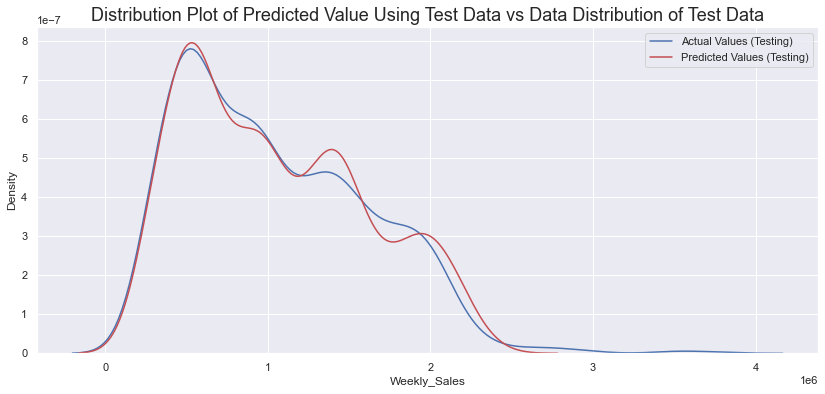

In [86]:
# Figure 3: Plot of predicted value using the test data compared to the actual values of the test data.
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
Distribution_Plot(Best_Tree, 'Testing', X_test_transformed, y_test, Title)

### Conclusion:

After testing the Decision Tree Regressor model, it became clear that it is the best model with an accuracy of around 92 % compared to the above algorithms we used (KNN).

## 4.Random Forest Regressor (Bagging)

In [87]:
# Random Forest regressor Model
rf = RandomForestRegressor()

# Fitting the training data
rf.fit(X_train_transformed, y_train)

RandomForestRegressor()

In [88]:
# Training Accuracy
model_evaluation(rf, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 55123.41
-> R-Squere score Training: 99.06 % 



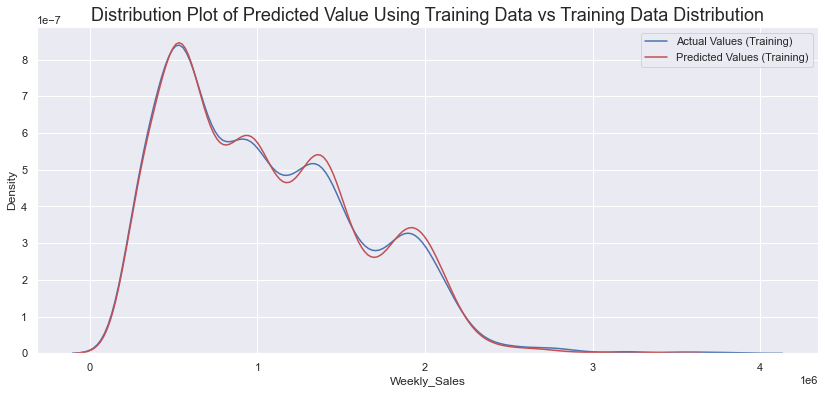

In [89]:
# Figure 1: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(rf, 'Training', X_train_transformed, y_train, Title)

#### Conclusion:

Has the model been overfitted?! let's be sure of that by doing a cross-validation score.

In [90]:
cross_validation_score(rf, X_train_transformed, y_train, n = 10)

Cross Validation Scores: [0.93849383 0.94176703 0.95115329 0.89685513 0.91346095 0.9395025
 0.95678356 0.9334832  0.92298897 0.93827394] 

Mean of Scores: 93.33 % 

Standard Deviation of Scores: 0.016912294763664147


#### Conclusion:

After doing a cross-validation score, we see the model has trained very well.

In [91]:
# Testing Accuracy
model_evaluation(rf, 'Testing', X_test_transformed, y_test)

Testing Accuracy: 

-> Root Mean Squared Error: 142086.15
-> R-Squere score Training: 93.83 % 



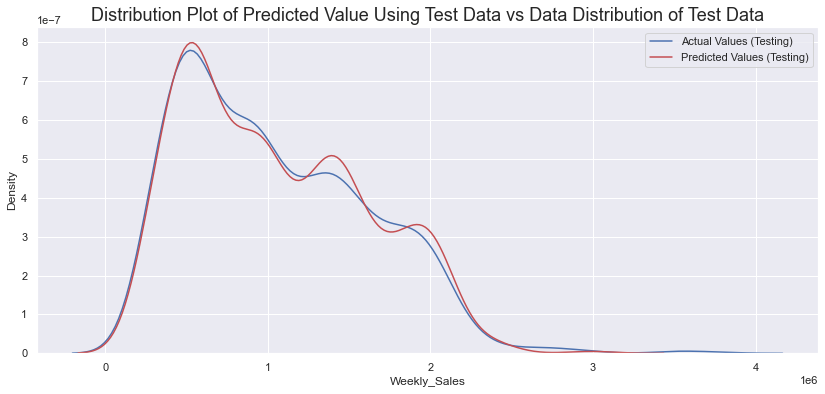

In [92]:
# Figure 3: Plot of predicted value using the test data compared to the actual values of the test data.
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
Distribution_Plot(rf, 'Testing', X_test_transformed, y_test, Title)

### Conclusion:

After testing the Random Forest Regressor model, it became clear that it is the best model with an accuracy of 93.84 % compared to the above algorithms we used (e.g. KNN, and Decision Tree Regressor).

## Decision Making: Determining a Good Model Fit

Now that we have visualized the different models, and generated the R-squared and MSE values for the fits, how do we determine a good model fit?

#### What is a good R-squared value?
When comparing models, the model with the higher R-squared value is a better fit for the data.

#### What is a good MSE?
When comparing models, the model with the smallest MSE value is a better fit for the data.

Comparing these four models, we conclude that The Linear Regression Model is the best model with an accuracy of 95.95 % to be able to predict weekly sales from our dataset.

## Time Series Analysis

### SARIMA

If there is seasonality a SARIMA (Seasonal ARIMA) model should be used. When applying an ARIMA model, we are ignoring seasonality and using only part of the information in the data. As a consequence, we are not making the best predictions possible.

SARIMA models include extra parameters related to the seasonal part. Indeed, we can see a SARIMA model as two ARIMA models combined: one dealing with non-seasonal part and another dealing with the seasonal part.

Therefore, a SARIMA(p,d,q)(P,D,Q,S) model have all the parameters described above (non-seasonal parameters) and P,D,Q,S that are the seasonal parameters, i.e.,

#### Non-seasonal orders

p: Autoregressive order

d: Differencing order

q: Moving average order

#### Seasonal orders

P: Seasonal autoregressive order

D: Seasonal differencing order

Q: Seasonal moving average order

S: Length of the seasonal cycle

In [93]:
data1=pd.read_csv("Walmart DataSet/Walmart DataSet.csv")
data1.set_index('Date', inplace=True)
# There are about 45 different stores in this dataset. Lets select the any store id from 1-45
store = data1[data1.Store == 15]
sales = pd.DataFrame(store.Weekly_Sales.groupby(store.index).sum())
sales.dtypes

Weekly_Sales    float64
dtype: object

In [94]:
sales.head()

,Weekly_Sales
Date,
01-04-2011,542556.05
01-06-2012,663971.26
01-07-2011,674669.16
01-10-2010,566945.95
02-03-2012,541292.64


In [95]:
sales.reset_index(inplace = True)
#converting 'date' column to a datetime type
sales['Date'] = pd.to_datetime(sales['Date'],yearfirst=True)
# resetting date back to the index
sales.set_index('Date',inplace = True)

In [96]:
sales.head()

,Weekly_Sales
Date,
2011-01-04,542556.05
2012-01-06,663971.26
2011-01-07,674669.16
2010-01-10,566945.95
2012-02-03,541292.64


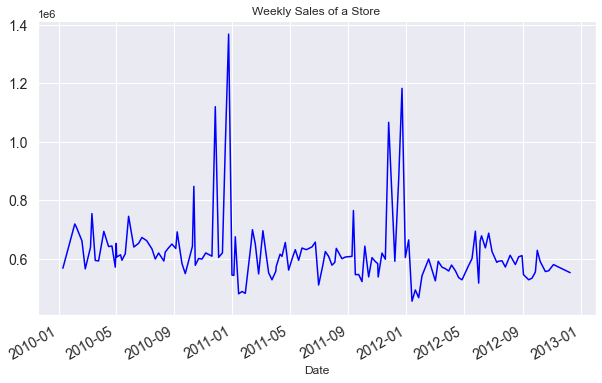

In [97]:
sales.Weekly_Sales.plot(figsize=(10,6), title= 'Weekly Sales of a Store', fontsize=14, color = 'blue')
plt.show()

<Figure size 432x288 with 0 Axes>

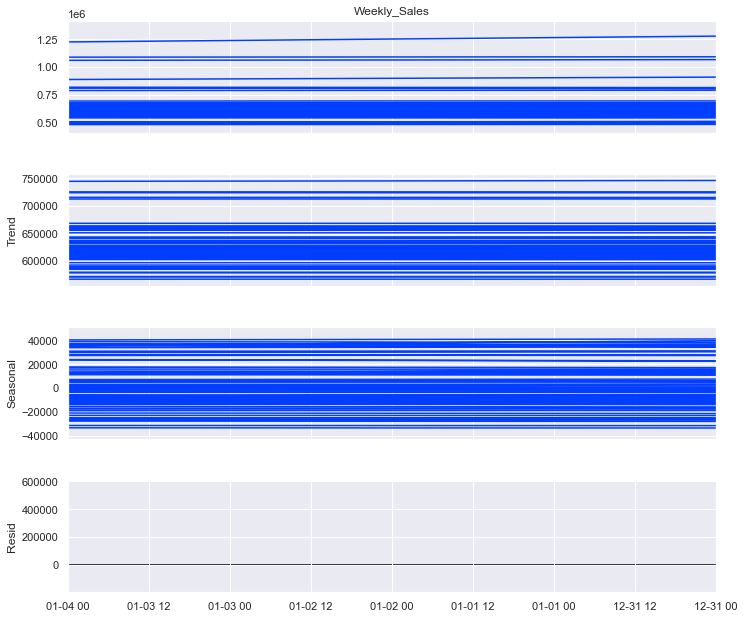

In [98]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(sales.Weekly_Sales, period=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 10)
plt.show()

In [99]:
#lets compare the 2012 data of two stores
# Lets take store 5 data for analysis
store5 = data1[data1.Store == 5]
# there are about 45 different stores in this dataset.

sales5 = pd.DataFrame(store5.Weekly_Sales.groupby(store5.index).sum())
sales5.dtypes
# Grouped weekly sales by store 6

#remove date from index to change its dtype because it clearly isnt acceptable.
sales5.reset_index(inplace = True)

#converting 'date' column to a datetime type
sales5['Date'] = pd.to_datetime(sales5['Date'])
# resetting date back to the index
sales5.set_index('Date',inplace = True)

In [100]:
y1=sales.Weekly_Sales
y2=sales5.Weekly_Sales

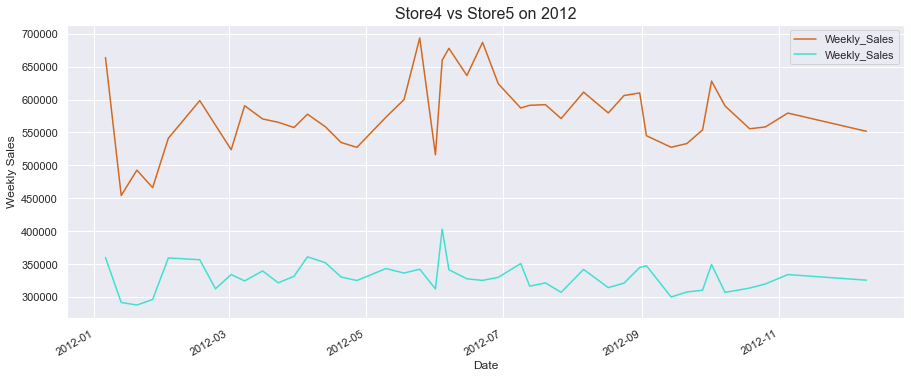

In [101]:
y1['2012'].plot(figsize=(15, 6),legend=True, color = 'chocolate')
y2['2012'].plot(figsize=(15, 6), legend=True, color = 'turquoise')
plt.ylabel('Weekly Sales')
plt.title('Store4 vs Store5 on 2012', fontsize = '16')
plt.show()

In [102]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 5)
import itertools
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

### Automated Model Selection

pmdarima allows us to automate the search of model orders. Automated Model Selection can speed up the process of choosing model orders, but needs to be done with care. Automation can make mistakes since the input data can be imperfect and affect the test scores in non-predictable ways.

The only non-optional parameter in auto_arima is data. However, using our knowledge to specify other parameters can help finding the best model.

In [103]:
# import pmdarima as pm

# # Create auto_arima model
# model1 = pm.auto_arima(sales, #time series
#                       seasonal=True, # is the time series seasonal
#                       m=52, # the seasonal period - one week?
#                       d=1, # non-seasonal difference order
#                       D=1, # seasonal difference order
#                  	  max_p=6, # max value of p to test 
#                       max_q=6, # max value of p to test
#                       max_P=6, # max value of P to test 
#                       max_Q=6, # max value of Q to test 
#                       information_criterion='aic', # used to select best mode
#                       trace=True, # prints the information_criterion for each model it fits
#                       error_action='ignore', # ignore orders that don't work
#                       stepwise=True, # apply an intelligent order search
#                       suppress_warnings=True) 

# # Print model summary
# print(model1.summary())

In [104]:
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(sales,
                                order=(2,1,3),
                                seasonal_order=(0, 1, 1, 52), #enforce_stationarity=False,
                                enforce_invertibility=False,
                               )

results = mod.fit()
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))

# Print mean absolute error
print('MAE: %.3f' % mae)

print(results.summary().tables[1])
    

MAE: 104180.304
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4811      0.302     -4.906      0.000      -2.073      -0.889
ar.L2         -0.6760      0.221     -3.059      0.002      -1.109      -0.243
ma.L1          0.8201      0.353      2.321      0.020       0.127       1.513
ma.L2         -0.4706      0.136     -3.466      0.001      -0.737      -0.204
ma.L3         -0.3210      0.322     -0.997      0.319      -0.952       0.310
ma.S.L52      -0.5661      0.252     -2.245      0.025      -1.060      -0.072
sigma2       3.38e+10    8.4e-12   4.02e+21      0.000    3.38e+10    3.38e+10


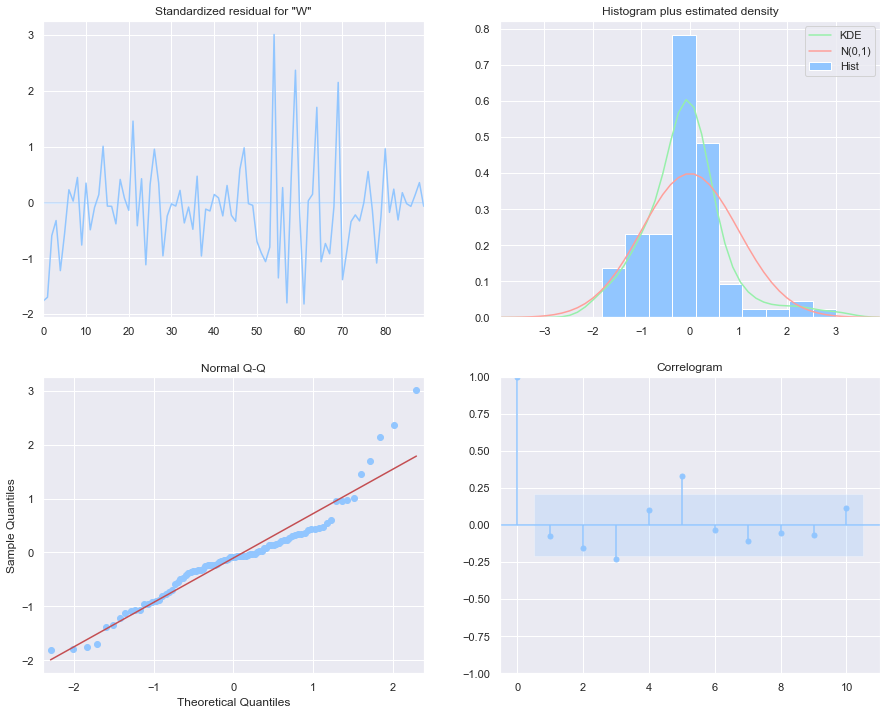

In [105]:
plt.style.use('seaborn-pastel')
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [106]:
pred = results.get_prediction(start=pd.to_datetime('2012-07-27'), dynamic=False)
pred_ci = pred.conf_int()

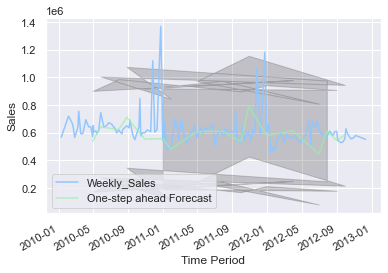

In [107]:
# ax = y1['2010':].plot(label='observed')
ax = sales.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

In [108]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2012-7-27'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [109]:
import numpy as np
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
print(y_forecasted)

Date
2012-07-27    612317.471599
2010-08-27    725039.290544
2011-01-28    508908.350019
2010-05-28    674275.567325
2012-09-28    583492.283947
2011-10-28    809841.986866
2011-04-29    663926.474085
2012-06-29    527641.399301
2011-07-29    654877.414561
2010-10-29    604559.138361
2012-03-30    615072.131412
2010-04-30    625596.007010
2010-07-30    607108.066341
2011-09-30    622708.339626
2011-12-30    575910.424206
2012-08-31    602609.160805
2010-12-31    559571.772328
Name: predicted_mean, dtype: float64


In [110]:
y_truth = y1['2012-7-27':]

print(y_truth)

Date
2012-08-06    611390.67
2012-09-03    545120.67
2012-10-02    628218.22
2012-10-08    590453.63
2012-11-05    579539.95
2012-12-10    551799.63
2012-09-14    527509.76
2012-08-17    579738.20
2012-10-19    555652.77
2012-09-21    533161.64
2012-08-24    606210.77
2012-10-26    558473.60
2012-07-27    571190.83
2012-09-28    553901.97
2012-08-31    610185.32
Name: Weekly_Sales, dtype: float64


In [111]:
Residual= y_forecasted - y_truth
print("Residual for Store1",np.abs(Residual).sum())

Residual for Store1 78293.11474064481


In [112]:
# Get forecast 12 weeks ahead in future
pred_uc = results.get_forecast(steps=12)

print(pred_uc)

In [113]:
# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

In [114]:
pred_ci

,lower Weekly_Sales,upper Weekly_Sales
143,227160.345078,9.562030e+05
144,203716.425754,9.734117e+05
145,250698.579634,1.030452e+06
146,179370.618104,1.054617e+06
147,111850.322064,9.904160e+05
148,123583.211217,1.076069e+06
149,86132.961936,1.050810e+06
150,172921.308834,1.175626e+06
151,91211.462006,1.122112e+06
152,94433.717529,1.146001e+06


## Predictions for all stores for 12 weeks

In [115]:
data1=pd.read_csv("Walmart DataSet/Walmart DataSet.csv")
data1.set_index('Date', inplace=True)
for i in list(data1['Store'].unique()):
    print(f"----------------- Store : {i} -----------------------")
    store = data1[data1.Store == i]
    sales = pd.DataFrame(store.Weekly_Sales.groupby(store.index).sum())
    sales.dtypes
    
    #remove date from index to change its dtype because it clearly isnt acceptable.
    sales.reset_index(inplace = True)
    #converting 'date' column to a datetime type
    sales['Date'] = pd.to_datetime(sales['Date'])
    # resetting date back to the index
    sales.set_index('Date',inplace = True)

    mod = sm.tsa.statespace.SARIMAX(sales,
                                    order=(2,1,3),
                                    seasonal_order=(0, 1, 1, 52), #enforce_stationarity=False,
                                    enforce_invertibility=False,
                                   )

    results = mod.fit()
    # Calculate the mean absolute error from residuals
    mae = np.mean(np.abs(results.resid))

    # Print mean absolute error
    print('MAE: %.3f' % mae)

#     print(results.summary().tables[1])

    pred = results.get_prediction(start=pd.to_datetime('2012-07-13'), dynamic=False)
    pred_ci = pred.conf_int()
    pred_dynamic = results.get_prediction(start=pd.to_datetime('2012-7-13'), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    
    y_forecasted = pred_dynamic.predicted_mean
    y_truth = y1['2012-7-13':]
    
#     Residual= y_forecasted - y_truth
#     print(f"Residual for Store {store} is {np.abs(Residual).sum()}")
    
    # Get forecast 12 weeks ahead in future
    pred_uc = results.get_forecast(steps=12)
    
    # Get confidence intervals of forecasts
    pred_ci = pred_uc.conf_int()
    
    #save the predictions
    with open(f'store_{i}.pkl','wb') as f:
        pickle.dump(pred_ci,f)

----------------- Store : 1 -----------------------
MAE: 154138.676
----------------- Store : 2 -----------------------
MAE: 211017.367
----------------- Store : 3 -----------------------
MAE: 47913.096
----------------- Store : 4 -----------------------
MAE: 241130.686
----------------- Store : 5 -----------------------
MAE: 39810.391
----------------- Store : 6 -----------------------
MAE: 212511.521
----------------- Store : 7 -----------------------
MAE: 111706.646
----------------- Store : 8 -----------------------
MAE: 98783.911
----------------- Store : 9 -----------------------
MAE: 68757.966
----------------- Store : 10 -----------------------
MAE: 254599.201
----------------- Store : 11 -----------------------
MAE: 156571.932
----------------- Store : 12 -----------------------
MAE: 128390.860
----------------- Store : 13 -----------------------
MAE: 252684.362
----------------- Store : 14 -----------------------
MAE: 338562.975
----------------- Store : 15 ------------------